In [1]:
#Import Liabraries
import pandas as pd
from collections import defaultdict, Counter
import os
from itertools import chain
import sklearn.preprocessing as skp
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import conll_utils
import time
from preprocessing_utils import SequenceEncoder
import matplotlib.pyplot as plt
import numpy as np
import matplotlit_utils
from sklearn.model_selection import train_test_split

In [2]:
%%time
dataset = conll_utils.from_dir('.../dataset_courts')

Wall time: 33 s


#### add  column ' sentences ' to the data frame

In [3]:
pred = dataset['predictors']
sentences = []
for sen in range(len(pred)):
    sentences.append("sentence {}".format(sen+1))
sentences
dataset.insert(0, "Sentences", sentences, True) 

In [4]:
df= dataset
df.head(2)

,Sentences,predictors,labels,file
0,sentence 1,"[Prozesskostenhilfe, -, Entschädigung, für, üb...","[O, O, O, O, O, O, O, O]",bag
1,sentence 2,"[Der, Antrag, auf, Gewährung, von, Prozesskost...","[O, O, O, O, O, O, O, O, O, O, O, B-AN, O, O, ...",bag


### Data preparation 

In [5]:
predictors, labels = df['predictors'], df['labels']

###### SequenceEncoder 
mimics the keras's Tokenizer utilities.

In [6]:
predictor_encoder = SequenceEncoder(max_sequence_len = 100)

In [7]:
predictor_encoder.fit(predictors)

###### assign a unique number to each unique word in predictors and extends/cuts each sentence in predictors to length of 100

In [8]:
print("Predictors before sequencing:\n {}". format(predictors[:1]))
encoded_words = predictor_encoder.transform(predictors) 
print("\nEncoded predictors:\n {}".format(encoded_words[:1]))

Predictors before sequencing:
 0    [Prozesskostenhilfe, -, Entschädigung, für, üb...
Name: predictors, dtype: object

Encoded predictors:
 0    [2740, 11, 2817, 18, 11822, 3894, 11, 792, 0, ...
Name: predictors, dtype: object


In [9]:
## 2D array of all rows in df['predictors'] , shape (66723, 100) 
words = np.array(encoded_words.tolist())  
## sorted list of all unique encoded words(their assigned numbers)
unique_words = np.unique(words)
## value of the largest encoded word
words_dim = unique_words[-1] 

###### assign a unique number to each label in labels

In [10]:
label_encoder = SequenceEncoder(max_sequence_len = 100, special_tokens = ['<EMPTY>'])
label_encoder.fit(labels)
print("labels before sequencing:\n{}". format(labels[:1]))
encoded_labels = label_encoder.transform(labels)
print("\nEncoded labels:\n{}".format(encoded_labels[:1]))

labels before sequencing:
0    [O, O, O, O, O, O, O, O]
Name: labels, dtype: object

Encoded labels:
0    [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...
Name: labels, dtype: object


In [11]:
labels_array = np.array(encoded_labels.tolist()) ## 2D array of all rows in df['labels'] , shape : 66723,100
labels_num = len(np.unique(labels_array))
print("Number of Labels: ",labels_num)

Number of Labels:  40


###### to_categorical:
represent each one of the labels in a unique binary vector

In [12]:
from tensorflow.keras.utils import to_categorical
y = [to_categorical(i,num_classes=40) for i in labels_array]  ## we have 39 classes and the 0
y[:1]

[array([[0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)]

###### binary_to_label: (reverses 'to_categorical'  function)
Reverse the binary representation of labels to their encoded form

In [13]:
def binary_to_label(binary_labels):
    reverse_ = []
    for y in binary_labels:
        reverse_.append(np.argmax(y, axis=-1))
    return reverse_

### Cross Validation 

In [14]:
## first we divide the dataset into k-folds
import sklearn
def shuffle_data(Data, Target):
    return sklearn.utils.shuffle(Data, Target, random_state=20)

def cross_validation(Data, Target, L):
    
    split_combination = []
    historia = []
    historia_split_num = []
    ## shuffle data and target in the same order.
    ##example data[[1,2],[4,5],[7,8]], target [10,11,12] => after shuffle ==> data[[4,5],[7,8],[1,2]], target [11,12,10]
    data_, target_ = shuffle_data(Data, Target)
        
    ## split data and target into L slices
    split_data = np.asarray(np.array_split(data_,L, axis = 0))
    split_target = np.array(np.array_split(target_, L))
    ## list to store errors rate of each slice prediction 
    errors = []
    ##for L slices take one slice as test and the rest as training
    for i in range(L):
        print("\nSlice Nr: {}\n".format(i+1))
        # test_data and test_target for a certain slice in L
        data_test = split_data[i]
        target_test = split_target[i]
        data_train = np.concatenate([split_data[j] for j in range(L) if j != i])
        target_train = np.concatenate([split_target[j] for j in range(L) if j != i])
        
        split_combination.append(([data_train, target_train] ,[data_test, target_test]))
        ## divide the training data, target to 20% validation data/target ##  or maybe not!
        historia.append(model_call(data_train, target_train, exec(f'LSTM_model_{i+1} = None')))
            
    return split_combination, historia 

In [15]:
def get_best_model(Data, Target, L): ## function calls train data on a model using cross validation
    
    Schuffled_target, cross_historia = cross_validation(Data, Target, L)  ## cross validation and train one model
    history_list = []
    ## this loops stores each of loss,accuracy, value_loss, value_accuracy in a list
    for i in cross_historia:
        history_list.append([val for v in i[0].history.values() for val in v]) 
    arr = np.vstack([val for val in history_list])
    loss_less = np.argmin((arr[:,[0,2]]),axis=0) ## these columns contain the loss and val loss 
    val_high = np.argmax((arr[:,[1,3]]),axis=0) ## these columns contain the accuracy and value accuracy
    loss_acc = np.concatenate((loss_less, val_high))
    most_frequent = np.argmax(np.bincount(loss_acc)) ## most frquent vector (vectors with the best results)
    best_ =  loss_acc[most_frequent]
    
    return cross_historia[best_] , Schuffled_target[best_] ## returns the best split, history and the model that was used

### Training LSTM model

In [16]:
from keras import Model, Input
from keras.models import Sequential
from keras.layers import Dense , Embedding ,LSTM
from keras import Model, Input
from keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import classification_report
import keras

In [17]:
def model_call(x_train, y_train, model):
    max_len = 100
    input_word = Input(shape =(max_len, ))
    model = Embedding(input_dim = words_dim+1, output_dim = max_len, input_length = max_len)(input_word)
    model = SpatialDropout1D(0.1)(model)
    model = Bidirectional(LSTM(units=100, return_sequences=True,recurrent_dropout=0.1))(model)
    out = TimeDistributed(Dense(40, activation='softmax'))(model)
    model = Model(input_word, out)
    model.summary()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model.fit(x_train, y_train, epochs=5, validation_split=0.2) , model

###### Split data into training and testing 
for the encoded_words will represent X_data, y (binary form of the labels) will represent Y_data

In [18]:
Data , Target = np.array(encoded_words.tolist()) , np.array(y)
Data.shape, Target.shape

((66723, 100), (66723, 100, 40))

In [20]:
best_model ,best_split = get_best_model(Data, Target,5)

C:\Users\Mazz Issa\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\Mazz Issa\anaconda3\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



Slice Nr: 1

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 100)          8158300   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 100, 100)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 200)          160800    
_________________________________________________________________
time_distributed (TimeDistri (None, 100, 40)           8040      
Total params: 8,327,140
Trainable params: 8,327,140
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
1335/1335 [==============================] - 673s 492ms/step - loss: 0.3656 - accuracy: 0.933

In [21]:
history, model = best_model[0], best_model[1]  ##  best_model contain history and the best model 
train_data, test_data = (best_split[0], best_split[1]) ## best split, contains traindata on one side and test data on the other

print(history, model)

<tensorflow.python.keras.callbacks.History object at 0x000002B4B7FBEF88> <tensorflow.python.keras.engine.functional.Functional object at 0x000002B3EE6757C8>


In [22]:
model.summary() ## the model that was choosen 

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 100)          8158300   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 100, 100)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 200)          160800    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 100, 40)           8040      
Total params: 8,327,140
Trainable params: 8,327,140
Non-trainable params: 0
_________________________________________________________________


In [20]:
from tensorflow import keras

#model.save("LSTM_Model")
LSTM = keras.models.load_model('C:/Users/Mazz Issa/Documents/Kurse/TA/Project/LegalNER-main/LegalNER-main/LEGAL_NER(D)/LSTM_model/lstm_model.h5')

### evaluation of the model

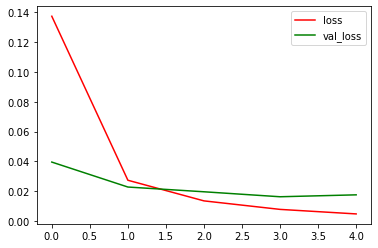

In [24]:
plt.plot(history.history['loss'], color='r', label='loss')
plt.plot(history.history['val_loss'], color='g', label = 'val_loss')
plt.legend()
plt.show()

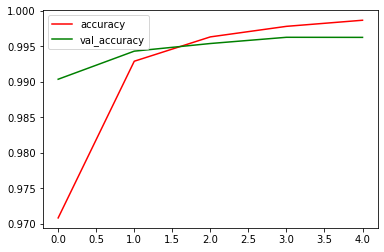

In [25]:
plt.plot(history.history['accuracy'], color='r', label='accuracy')
plt.plot(history.history['val_accuracy'], color='g', label = 'val_accuracy')
plt.legend()
plt.show()

### The accuracy and the value accuracy seem to be really hight but in our case this doest really see much about how our model worked, what could be more usefull is, to check the precision of each label after testing!

### DataFrame of the prediction

In [23]:
def test_to_df(test_data, model):
    ## get the predicted labels 
    result = np.round(model.predict(test_data))  ## model.predicts returns values between 0 and 1, therefore, round the results
    ## change the predicted labels from binary to their encoded sequence and reverse the sequence to labels
    result = binary_to_label(result)
    predicted_labels = label_encoder.reverse(result) 
    
    ## reverse the test_data sequence to words
    test_df = pd.Series(test_data.tolist()) 
    test_words = predictor_encoder.reverse(test_df)
    
    ## create a Dataframe
    return pd.DataFrame(zip(test_words,predicted_labels), columns=['predictors_test', 'labels_test'])

### Evaluate result precision

In [43]:
## this function calculates the precision, recall, f1-score to each for all labels in the passed parameters
def get_accuracy(Xtest_data, Ytest_data, model, target_names=None):
    
    pred = np.round(model.predict(Xtest_data))
    pred = binary_to_label(pred)
    y_test = binary_to_label(Ytest_data)
    
    pred_ = np.concatenate(pred).ravel().tolist()
    y_ = np.concatenate(y_test).ravel().tolist()
    
    return classification_report(y_, pred_, target_names, output_dict=True)

In [28]:
prediction_df = test_to_df(test_data[0],model)

In [29]:
prediction_df.sample(10)

,predictors_test,labels_test
8344,"[Nach, §, 7, Nr., 3, VTV, hat, der, Arbeitgebe...","[O, B-VT, I-VT, I-VT, I-VT, I-VT, O, O, O, O, ..."
5595,"[Insofern, gibt, es, auch, im, Rahmen, von, un...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-I..."
3827,"[„, §, 1]","[O, O, O]"
11825,"[Der, Kläger, hat, aber, -, was, zwischen, den...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
11158,"[Die, Schnittstellenfunktion, ist, zudem, erke...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
8832,"[Ob, im, Einzelfall, eine, Terminsverlegung, g...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
12317,"[Vorliegend, stehen, sich, die, angegriffene, ...","[O, O, O, O, O, O, O, O, O, O, O, B-MRK, O, O]"
1619,"[Im, Falle, des, Klägers, ist, weder, die, Alt...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
11210,"[Zwar, werde, das, Erzeugnis, im, Grundpatent,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
12359,"[§, 11, Ziff., 3, MTV, Systemgastronomie, 2014...","[B-VT, I-VT, I-VT, I-VT, I-VT, I-VT, I-VT, O, ..."


In [30]:
model_accuracy = get_accurcy(test_data[0], test_data[1],model)
print(model_accuracy)

C:\Users\Mazz Issa\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=None as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
C:\Users\Mazz Issa\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    911363
           1       0.99      1.00      0.99    344168
           2       0.99      0.98      0.98     34041
           3       0.99      0.96      0.98     19512
           4       0.97      0.89      0.93      6058
           5       0.99      0.95      0.97      3731
           6       0.97      0.95      0.96      2420
           7       0.87      0.88      0.87      2405
           8       0.95      0.84      0.89      2260
           9       0.95      0.86      0.90       877
          10       0.79      0.70      0.75       797
          11       0.93      0.49      0.64       855
          12       0.94      0.91      0.92       638
          13       0.95      0.80      0.87       527
          14       0.88      0.88      0.88       566
          15       0.93      0.85      0.89       490
          16       0.93      0.88      0.91       407
          17       0.90    

## Classification report 

In [ ]:
## i used this cell because i tested trained the model then saved the model, then i reloaded the made and tested on a later time 
## and had to re split the data in the following cell and check the precision 
Data_, Target_ = shuffle_data(Data, Target)

X_test = Data_[round(Data_.shape[0]/5):(round(Data_.shape[0]/5)*2)]
Y_test = Target_[round(Data_.shape[0]/5):(round(Data_.shape[0]/5)*2)]
report = get_accuracy(X_test, Y_test,LSTM)
df = pd.DataFrame(report)


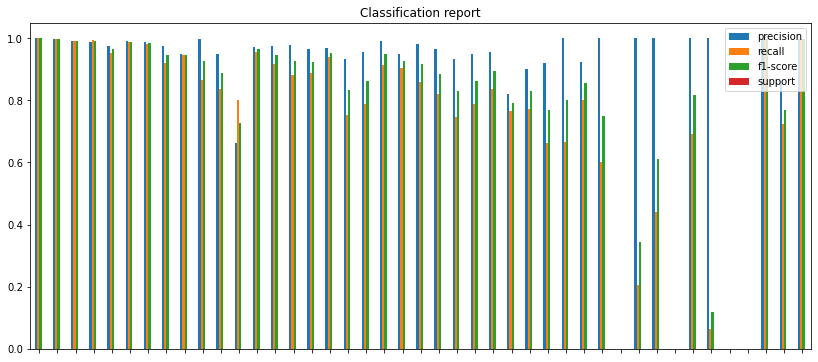

In [72]:
df.loc[df.index == 'support', :] = oo[df.index != 'support'].apply(lambda x: x / float(n_points))
ax = df.transpose().plot.bar(figsize=(14, 6), title='Classification report', )
_ = ax.set_xticklabels(classes_list)
plt.savefig(os.path.join(store_path,name+'.png'))

#### The precision overall is turned out to be good, the only flaw is couple of the Labels appeared less than 5% of the times, these labels were mostly mispredicted and some were even ignored 